#Import Libraries

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vacances_scolaires_france import SchoolHolidayDates
import holidays
from dateutil.easter import easter
import calendar
import datetime

%matplotlib inline

# some settings for graphics
sns.set_style("dark")
sns.set(rc={'figure.figsize':(12,4)})

# use this value where it is possible to indicate the random state
RANDOM_STATE = 42

#Load dataset

In [297]:
data = pd.read_csv("data_passagers.csv")
data.head()

,dateTime,weather,lineNumber,passengersNumber,lineType
0,2019-04-05,26,29,3032,daily
1,2019-04-05,26,42,418,daily
2,2019-04-05,26,40,2065,daily
3,2019-04-05,26,104,115,night
4,2019-04-05,26,27,2900,daily


In [298]:
data["lineType"].unique()

array(['daily', 'night'], dtype=object)

In [299]:
len(data["weather"].unique())

22

#Data Preprocessing

In [300]:
# Conversion de la colonne datetime
data['dateTime'] = pd.to_datetime(data['dateTime'])

In [301]:
# Jours fériés en France
fr_holidays = holidays.France()
d  =  SchoolHolidayDates ()

# Extraction d'autres composantes

data['year'] = data['dateTime'].dt.year  # Année
data['dateTimeMonth'] = data['dateTime'].dt.month  # Mois
data['dateTimeDay'] = data['dateTime'].dt.day  # Jour

# Extraire le numéro de la semaine
data['dateTimeWeek'] = data['dateTime'].dt.isocalendar().week

# Extraire le jour de l'annee (1 to 365)
data['day_of_year'] = data['dateTime'].apply(lambda x: x.timetuple().tm_yday)

# Extraire le jour de la semaine
data['dateTimeDayofweek'] = data['dateTime'].dt.dayofweek

# Dimanche ou non
data['dateTimeIs_sunday'] = data['dateTimeDayofweek'].isin([6])

# Jour ferie oui ou non
data['is_holiday'] = data['dateTime'].dt.date.isin(fr_holidays)

# Extraire les années présentes dans le DataFrame
years = data['year'].unique()

# Obtenir les dates des vacances scolaires pour chaque année et les combiner
school_holidays = SchoolHolidayDates()
vacation_days = set()
i = 0
for dat in data['dateTime']:
    holidays = school_holidays.is_holiday_for_zone(datetime.date(dat.year,dat.month,dat.day), "A")
    # Ajouter une colonne indiquant si la date est un jour de vacances scolaires
    data.loc[i, 'dateTimeIs_schoolholiday'] = holidays
    i+=1

# Jour de paque ou non
# Calculer les dates de Pâques pour chaque année et créer un dictionnaire
easter_dates = {year: easter(year) for year in years}

# Ajouter une colonne indiquant si la date est un jour de Pâques
data['dateTimeIs_paques'] = data['dateTime'].dt.date.apply(lambda x: x == easter_dates.get(x.year))
#

#Grande semaine
# Calculer les plages de la "Grande Semaine" pour chaque année
semana_santa_ranges = {
    year: pd.date_range(start=easter(year) - pd.Timedelta(days=7), end=easter(year)).date
    for year in years
}

# Ajouter une colonne indiquant si la date est dans la "Grande Semaine"
data['dateTimeIs_grandsemaine '] = data['dateTime'].dt.date.apply(
    lambda x: x in semana_santa_ranges.get(x.year, [])
)

data

,dateTime,weather,lineNumber,passengersNumber,lineType,year,dateTimeMonth,dateTimeDay,dateTimeWeek,day_of_year,dateTimeDayofweek,dateTimeIs_sunday,is_holiday,dateTimeIs_schoolholiday,dateTimeIs_paques,dateTimeIs_grandsemaine
0,2019-04-05,26,29,3032,daily,2019,4,5,14,95,4,False,False,False,False,False
1,2019-04-05,26,42,418,daily,2019,4,5,14,95,4,False,False,False,False,False
2,2019-04-05,26,40,2065,daily,2019,4,5,14,95,4,False,False,False,False,False
3,2019-04-05,26,104,115,night,2019,4,5,14,95,4,False,False,False,False,False
4,2019-04-05,26,27,2900,daily,2019,4,5,14,95,4,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37616,2023-03-19,26,26,2650,daily,2023,3,19,11,78,6,True,False,False,False,False
37617,2023-03-19,26,31,905,daily,2023,3,19,11,78,6,True,False,False,False,False
37618,2023-03-19,26,36,425,daily,2023,3,19,11,78,6,True,False,False,False,False
37619,2023-03-19,26,41,273,daily,2023,3,19,11,78,6,True,False,False,False,False


In [302]:
# Grouper par année et numéro de ligne de bus pour calculer le total des passagers
grouped = data.groupby(['year', 'lineNumber'])['passengersNumber'].sum().reset_index()

In [303]:
# Sort data by dateTime for lag calculation
data = data.sort_values(by=['dateTime'])


# Add lag features
data['nbPassenger_lag1'] = data['passengersNumber'].shift(7)
data['nbPassenger_lag2'] = data['passengersNumber'].shift(14)
data['nbPassenger_lag3'] = data['passengersNumber'].shift(21)

# Replace NaN values in lag variables with the mean of their respective columns
data['nbPassenger_lag1'] = data['nbPassenger_lag1'].fillna(data['nbPassenger_lag1'].mean())
data['nbPassenger_lag2'] = data['nbPassenger_lag2'].fillna(data['nbPassenger_lag2'].mean())
data['nbPassenger_lag3'] = data['nbPassenger_lag3'].fillna(data['nbPassenger_lag3'].mean())



In [304]:
data['dateTimeIs_sunday']

0        False
22       False
23       False
24       False
25       False
         ...  
37593     True
37592     True
37619     True
37605     True
37620     True
Name: dateTimeIs_sunday, Length: 37621, dtype: bool

### Ajout des donnees Meteorologiques

In [305]:
dictA = {
    1: "Très pluvieux",
    2: "Pluvieux",
    3: "Très nuageux",
    4: "Partiellement nuageux",
    5:"Ensoleillé"
}

dictB = {
1:["Nuboso con tormenta", "Muy nuboso con nieve escasa", "Nuboso con tormenta y lluvia escasa noche",
    "Nuboso con tormenta y lluvia escasa", "Nuboso con tormenta noche", "Cubierto con nieve escasa",
    "Muy nuboso con tormenta y lluvia escasa", "Cubierto con lluvia", "Intervalos nubosos con tormenta y lluvia escasa",
      "Cubierto con tormenta y lluvia escasa", "Cubierto con nieve", "Nuboso con nieve noche", "Muy nuboso con tormenta",
      "Nuboso con nieve",  "Muy nuboso con nieve", "Cubierto con tormenta",  "Intervalos nubosos con tormenta y lluvia escasa noche",
      "Muy nuboso con lluvia"],
2:["Intervalos nubosos con tormenta noche", "Intervalos nubosos con nieve escasa", "Nuboso con lluvia noche",
   "Nuboso con lluvia", "Intervalos nubosos con nieve noche", "Cubierto con lluvia escasa", "Intervalos nubosos con nieve",
   "Intervalos nubosos con tormenta", "Nuboso con nieve escasa", "Intervalos nubosos con nieve escasa noche",
   "Nuboso con nieve escasa noche", "Muy nuboso con lluvia escasa"],
3:["Intervalos nubosos con lluvia noche", "Intervalos nubosos con lluvia", "Nuboso con lluvia escasa noche",
   "Nuboso con lluvia escasa", "Muy nuboso", "Nuboso", "Intervalos nubosos con lluvia escasa",  "Cubierto",
   "Intervalos nubosos con lluvia escasa noche"],
4:["Nuboso noche", "Nubes altas", "Intervalos nubosos", "Intervalos nubosos noche", "Nubes altas noche"],
5:["Despejado", "Poco nuboso", "Despejado noche", "Poco nuboso noche"]
}

dictC = {
12 : "Muy nuboso con lluvia escasa",
13 : "Intervalos nubosos",
43 : "Intervalos nubosos con lluvia escasa",
26 : "Cubierto con lluvia",
25 :  "Muy nuboso con lluvia",
11 :  "Despejado",
62 :  "Nuboso con tormenta y lluvia escasa",
24 : "Nuboso con lluvia",
23 : "Intervalos nubosos con lluvia",
61 : "Intervalos nubosos con tormenta y lluvia escasa",
53 : "Muy nuboso con tormenta",
52 : "Nuboso con tormenta",
51 :  "Intervalos nubosos con tormenta",
17 : "Nubes altas",
44 : "Nuboso con lluvia escasa",
15 : "Muy nuboso",
14 : "Nuboso",
45 : "Muy nuboso con lluvia escasa",
46 : "Cubierto con lluvia escasa",
16 : "Cubierto",
13 : "Intervalos nubosos",
54 : "Cubierto con tormenta"
}

In [306]:
# Parcourir les valeurs de dictC
for k in dictC.values():
    # Vérifier si la valeur k apparaît dans une des listes de dictB
    if any(k in valeurs for valeurs in dictB.values()):
        print(k)



Muy nuboso con lluvia escasa
Intervalos nubosos
Intervalos nubosos con lluvia escasa
Cubierto con lluvia
Muy nuboso con lluvia
Despejado
Nuboso con tormenta y lluvia escasa
Nuboso con lluvia
Intervalos nubosos con lluvia
Intervalos nubosos con tormenta y lluvia escasa
Muy nuboso con tormenta
Nuboso con tormenta
Intervalos nubosos con tormenta
Nubes altas
Nuboso con lluvia escasa
Muy nuboso
Nuboso
Muy nuboso con lluvia escasa
Cubierto con lluvia escasa
Cubierto
Cubierto con tormenta


In [307]:
# Parcourir les valeurs de dictC
for k in dictC.values():
    v = 0
    for i in dictB.values():
        if k in i:
            print(list(dictB.keys())[v])
        v+=1

2
4
3
1
1
5
1
2
3
1
1
1
2
4
3
3
3
2
2
3
1


In [308]:
dictC[12]

'Muy nuboso con lluvia escasa'

In [309]:
# Ajouter une nouvelle colonne vide pour Dweather
data["Dweather"] = None

# Parcourir chaque ligne du DataFrame
for index, row in data.iterrows():
    weather_key = row["weather"]  # Clé de weather dans dictC

    # Vérifier si la clé existe dans dictC
    if weather_key in dictC:
        weather_value = dictC[weather_key]  # Obtenir la valeur associée

        # Trouver dans dictB où cette valeur correspond
        for key, values in dictB.items():
            if weather_value in values:
                # Associer à la bonne valeur de dictA
                data.at[index, "Dweather"] = key
                break  # Arrêter la recherche dès qu'une correspondance est trouvée


In [310]:
data["Dweather"].unique()

array([1, 3, 2, 4, 5, None], dtype=object)

In [311]:
data


,dateTime,weather,lineNumber,passengersNumber,lineType,year,dateTimeMonth,dateTimeDay,dateTimeWeek,day_of_year,dateTimeDayofweek,dateTimeIs_sunday,is_holiday,dateTimeIs_schoolholiday,dateTimeIs_paques,dateTimeIs_grandsemaine,nbPassenger_lag1,nbPassenger_lag2,nbPassenger_lag3,Dweather
0,2019-04-05,26,29,3032,daily,2019,4,5,14,95,4,False,False,False,False,False,2068.069416,2068.118808,2068.198059,1
22,2019-04-05,26,33,4880,daily,2019,4,5,14,95,4,False,False,False,False,False,2068.069416,2068.118808,2068.198059,1
23,2019-04-05,26,16,1000,daily,2019,4,5,14,95,4,False,False,False,False,False,2068.069416,2068.118808,2068.198059,1
24,2019-04-05,26,14,4355,daily,2019,4,5,14,95,4,False,False,False,False,False,2068.069416,2068.118808,2068.198059,1
25,2019-04-05,26,109,36,night,2019,4,5,14,95,4,False,False,False,False,False,2068.069416,2068.118808,2068.198059,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37593,2023-03-19,26,13,6060,daily,2023,3,19,11,78,6,True,False,False,False,False,784.000000,230.000000,196.000000,1
37592,2023-03-19,26,6,21,daily,2023,3,19,11,78,6,True,False,False,False,False,3684.000000,345.000000,1074.000000,1
37619,2023-03-19,26,41,273,daily,2023,3,19,11,78,6,True,False,False,False,False,1883.000000,7073.000000,1377.000000,1
37605,2023-03-19,26,27,678,daily,2023,3,19,11,78,6,True,False,False,False,False,1074.000000,1109.000000,458.000000,1


In [350]:
# Preprocess dateTime and encode lineType

data['lineType_encoded'] = data['lineType'].map({'daily': 1, 'night': 0})

# X = data[['dateTime','weather','year', 'dateTimeMonth','dateTimeWeek','dateTimeDay','day_of_year','dateTimeDayofweek','dateTimeIs_sunday', 'lineNumber', 'lineType_encoded','is_holiday','dateTimeIs_paques','nbPassenger_lag1', 'nbPassenger_lag2', 'nbPassenger_lag3']]

X = data[['weather','year', 'dateTimeMonth','dateTimeWeek','dateTimeDay','day_of_year','dateTimeDayofweek','dateTimeIs_sunday', 'lineNumber', 'lineType_encoded','is_holiday','dateTimeIs_paques','nbPassenger_lag1', 'nbPassenger_lag2', 'nbPassenger_lag3','Dweather']]

y = data['passengersNumber']


#Data Exploration

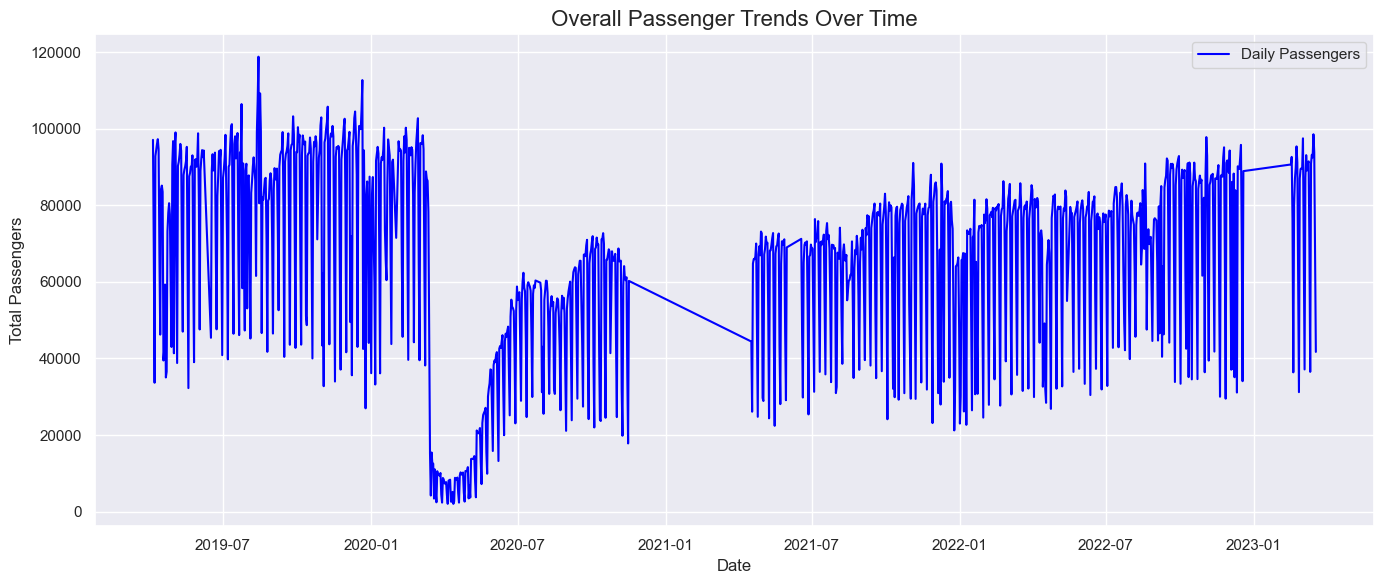

In [313]:
# l'évolution générale du nombre de passagers
daily_passengers = data.groupby('dateTime')['passengersNumber'].sum().reset_index()
plt.figure(figsize=(14, 6))
plt.plot(daily_passengers['dateTime'], daily_passengers['passengersNumber'], label='Daily Passengers', color='blue')
plt.title("Overall Passenger Trends Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Passengers", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

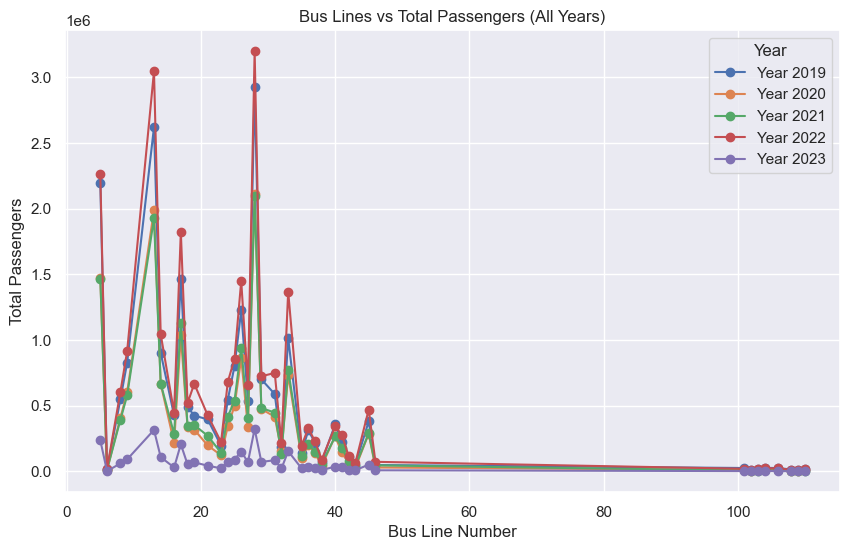

In [314]:
#Évolution du nombre de passagers par ligne de bus au fil des années

# Tracer un graphique combiné
plt.figure(figsize=(10, 6))  # Taille du graphique

# Boucle sur chaque année pour tracer les données correspondantes
unique_years = grouped['year'].unique()
for year in unique_years:
    # Filtrer les données pour l'année en cours
    year_data = grouped[grouped['year'] == year]

    # Tracer les lignes avec une couleur différente pour chaque année
    plt.plot(
        year_data['lineNumber'],
        year_data['passengersNumber'],
        marker='o',
        label=f"Year {year}"
    )

# Personnalisation du graphique
plt.title("Bus Lines vs Total Passengers (All Years)")
plt.xlabel("Bus Line Number")
plt.ylabel("Total Passengers")
plt.legend(title="Year")  # Légende avec un titre
plt.grid(True)

# Afficher le graphique
plt.show()

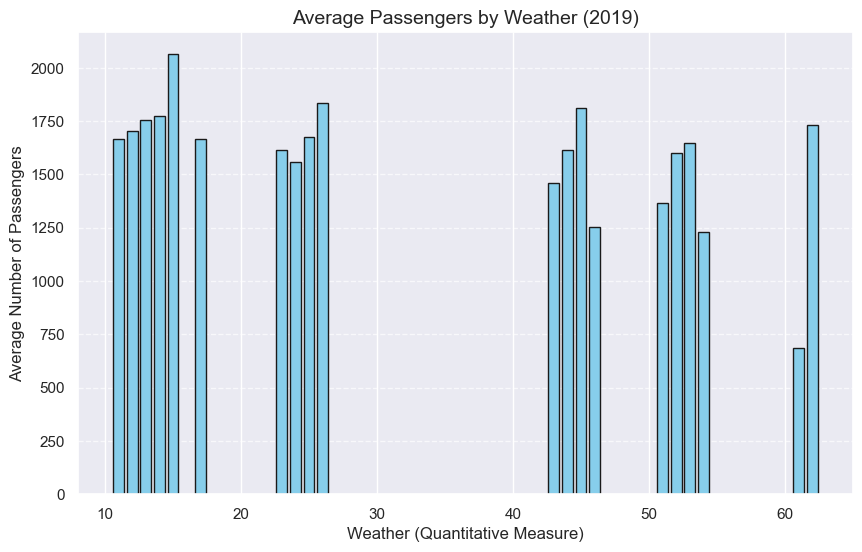

In [315]:
# Filtrer pour l'année 2019
passagers_df_2019 =data[data['dateTime'].dt.year == 2020]

# Calculer la moyenne des passagers par météo
weather_passengers =passagers_df_2019.groupby('weather')['passengersNumber'].mean().reset_index()

# Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(weather_passengers['weather'], weather_passengers['passengersNumber'], color='skyblue', edgecolor='k')

# Personnalisation du graphique
plt.title("Average Passengers by Weather (2019)", fontsize=14)
plt.xlabel("Weather (Quantitative Measure)", fontsize=12)
plt.ylabel("Average Number of Passengers", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

In [316]:
#Total des passagers par date/heure
data.groupby("dateTime")["passengersNumber"].sum().reset_index()

,dateTime,passengersNumber
0,2019-04-05,97085
1,2019-04-06,68790
2,2019-04-07,33649
3,2019-04-08,92820
4,2019-04-10,96029
...,...,...
1182,2023-03-15,92501
1183,2023-03-16,98543
1184,2023-03-17,93866
1185,2023-03-18,68811


In [317]:
data.describe(include = "object")

,lineType,dateTimeIs_schoolholiday,Dweather
count,37621,37621,37590
unique,2,2,5
top,daily,False,1
freq,34946,23913,12134


In [318]:
#Résumé des informations du DataFrame des passagers
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37621 entries, 0 to 37620
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   dateTime                  37621 non-null  datetime64[ns]
 1   weather                   37621 non-null  int64         
 2   lineNumber                37621 non-null  int64         
 3   passengersNumber          37621 non-null  int64         
 4   lineType                  37621 non-null  object        
 5   year                      37621 non-null  int32         
 6   dateTimeMonth             37621 non-null  int32         
 7   dateTimeDay               37621 non-null  int32         
 8   dateTimeWeek              37621 non-null  UInt32        
 9   day_of_year               37621 non-null  int64         
 10  dateTimeDayofweek         37621 non-null  int32         
 11  dateTimeIs_sunday         37621 non-null  bool          
 12  is_holiday             

In [319]:
data.columns

Index(['dateTime', 'weather', 'lineNumber', 'passengersNumber', 'lineType',
       'year', 'dateTimeMonth', 'dateTimeDay', 'dateTimeWeek', 'day_of_year',
       'dateTimeDayofweek', 'dateTimeIs_sunday', 'is_holiday',
       'dateTimeIs_schoolholiday', 'dateTimeIs_paques',
       'dateTimeIs_grandsemaine ', 'nbPassenger_lag1', 'nbPassenger_lag2',
       'nbPassenger_lag3', 'Dweather', 'lineType_encoded'],
      dtype='object')

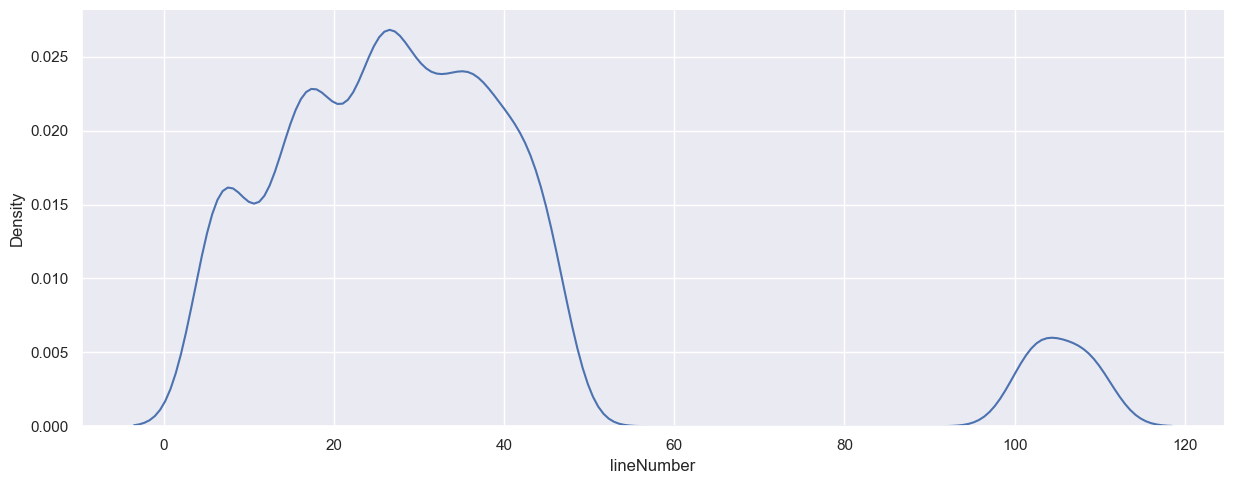

In [320]:
#Distribution de la densité des lignes de bus
sns.displot(x='lineNumber', data=data, kind='kde', aspect=2.5)

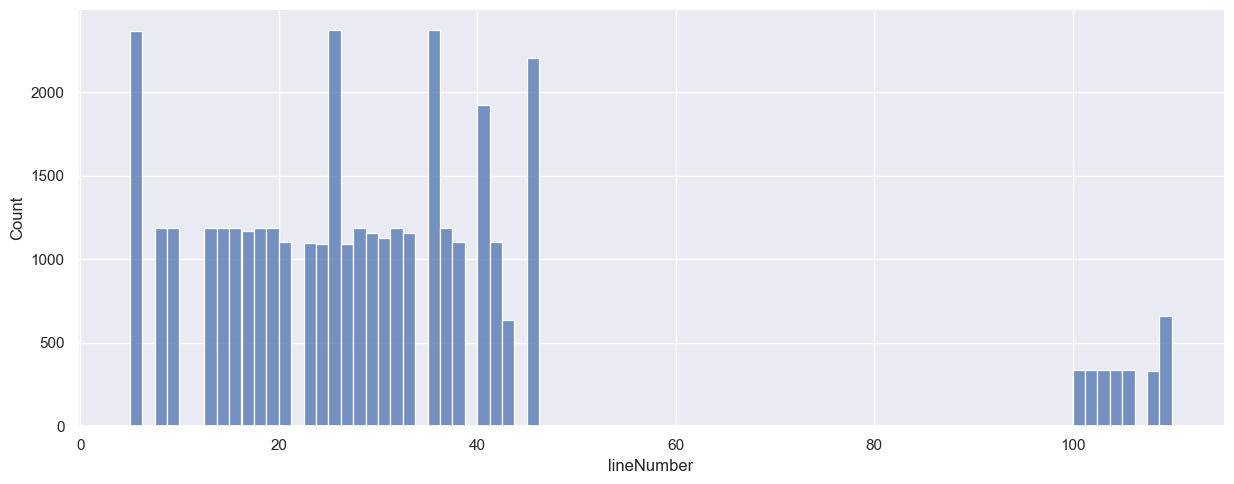

In [321]:
#Distribution des lignes de bus
sns.displot(x='lineNumber', data=data, kind='hist', aspect=2.5)

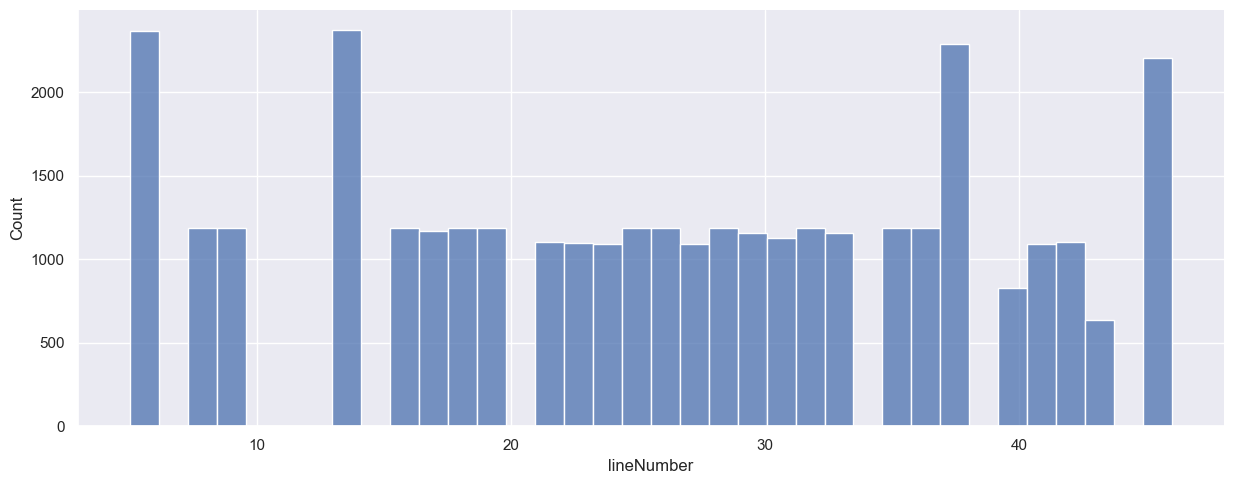

In [322]:
#Distribution des lignes de bus (numéros inférieurs à 60)
sns.displot(x='lineNumber', data=data[data['lineNumber'] < 60], kind='hist', aspect=2.5)

In [323]:
len(data['lineNumber'].unique())

39

In [324]:
data['year'].unique()

array([2019, 2020, 2021, 2022, 2023], dtype=int32)

#Visualisation

In [325]:
resyear = data.groupby('year').agg(total_passenger=('passengersNumber', 'sum'))
resyear

,total_passenger
year,
2019,21111151
2020,14663240
2021,15280654
2022,24216762
2023,2526201


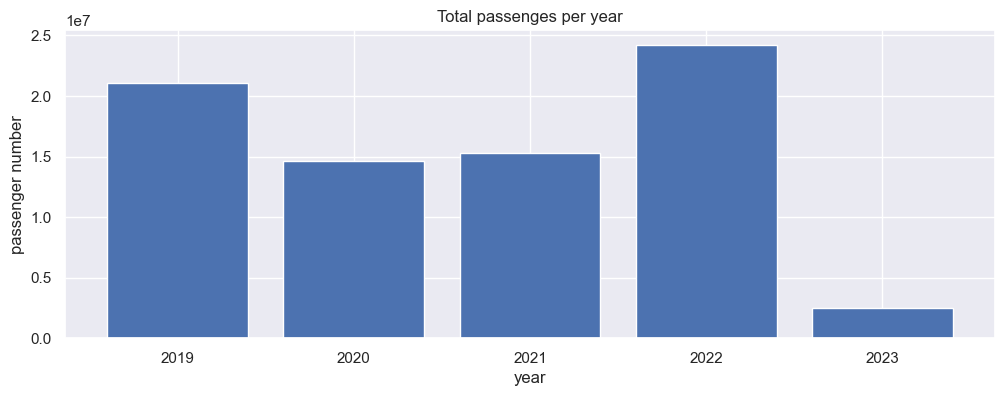

In [326]:
#Nombre total de passagers par année
fig, axs = plt.subplots(1,1,figsize=(12, 4))

axs.bar(resyear.index, resyear.total_passenger)
axs.set_title('Total passenges per year')
axs.set_xlabel('year')
axs.set_ylabel('passenger number')
plt.show()

In [327]:
#Total des passagers par mois en 2019
res2019 = data.loc[data['dateTime'].dt.year == 2019, ].groupby('dateTimeMonth').agg(total_passenger=('passengersNumber', 'sum'))
res2019

,total_passenger
dateTimeMonth,
4,1758114
5,2485487
6,1765393
7,2458607
8,2568710
9,2489239
10,2602059
11,2487465
12,2496077


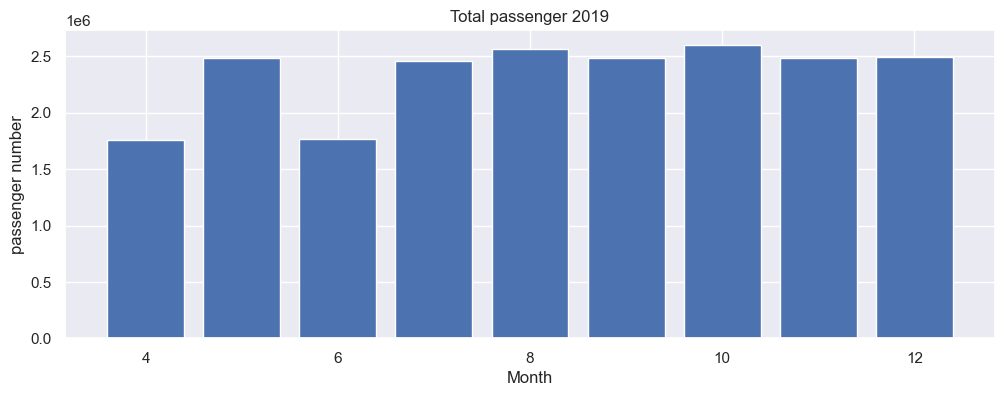

In [328]:
#Total des passagers en 2019
fig, axs = plt.subplots(1,1,figsize=(12, 4))

axs.bar(res2019.index, res2019.total_passenger)
axs.set_title('Total passenger 2019')
axs.set_xlabel('Month')
axs.set_ylabel('passenger number')
plt.show()

In [329]:
#Nombre d'enregistrements par ligne de bus
resline = data.groupby('lineNumber').agg(total_passenger=('passengersNumber', 'size'))
resline

,total_passenger
lineNumber,
5,1187
6,1182
8,1187
9,1187
13,1187
14,1187
16,1187
17,1168
18,1187


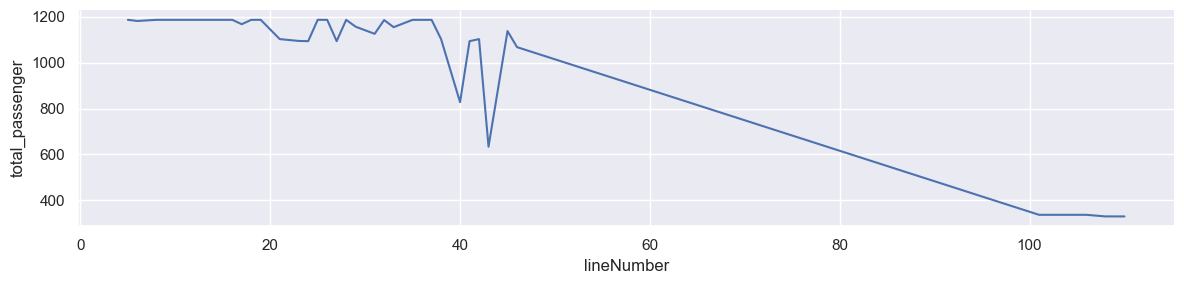

In [330]:
sns.relplot(data=resline, x='lineNumber', y='total_passenger', kind='line', height=3, aspect=4)
plt.show()

In [331]:
#Lignes de bus avec plus de 1000 passagers
resline.loc[resline['total_passenger'] > 1000, ]

,total_passenger
lineNumber,
5,1187
6,1182
8,1187
9,1187
13,1187
14,1187
16,1187
17,1168
18,1187


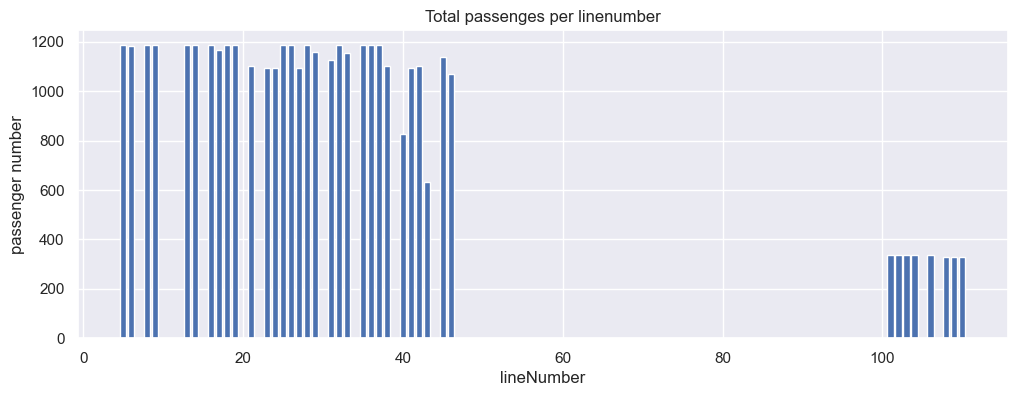

In [332]:
fig, axs = plt.subplots(1,1,figsize=(12, 4))

axs.bar(resline.index, resline.total_passenger)
axs.set_title('Total passenges per linenumber')
axs.set_xlabel('lineNumber')
axs.set_ylabel('passenger number')
plt.show()

In [333]:
#Nombre d'enregistrements par type de ligne de bus (jour vs nuit)
reslinetype = data.groupby('lineType').agg(total_passenger=('passengersNumber', 'size'))
reslinetype

,total_passenger
lineType,
daily,34946
night,2675


In [334]:
reslinetype.index

Index(['daily', 'night'], dtype='object', name='lineType')

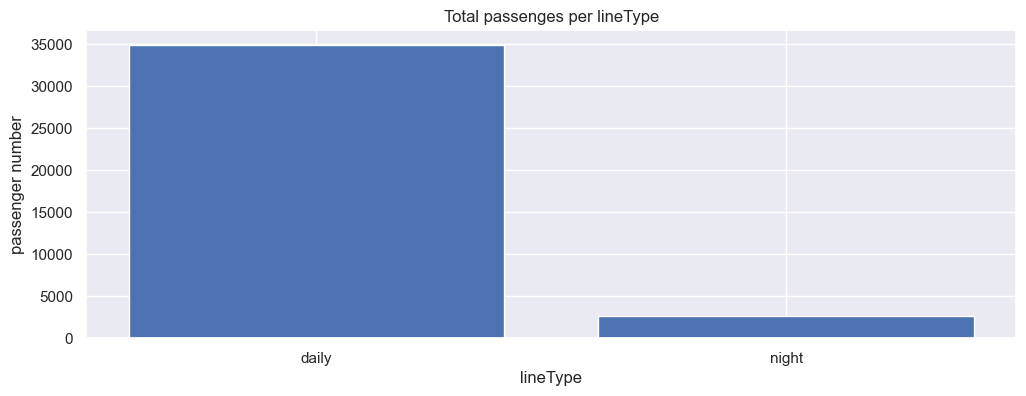

In [335]:
fig, axs = plt.subplots(1,1,figsize=(12, 4))

axs.bar(reslinetype.index, reslinetype.total_passenger)
axs.set_title('Total passenges per lineType')
axs.set_xlabel('lineType')
axs.set_ylabel('passenger number')
plt.show()

In [336]:
data.head()

,dateTime,weather,lineNumber,passengersNumber,lineType,year,dateTimeMonth,dateTimeDay,dateTimeWeek,day_of_year,...,dateTimeIs_sunday,is_holiday,dateTimeIs_schoolholiday,dateTimeIs_paques,dateTimeIs_grandsemaine,nbPassenger_lag1,nbPassenger_lag2,nbPassenger_lag3,Dweather,lineType_encoded
0,2019-04-05,26,29,3032,daily,2019,4,5,14,95,...,False,False,False,False,False,2068.069416,2068.118808,2068.198059,1,1
22,2019-04-05,26,33,4880,daily,2019,4,5,14,95,...,False,False,False,False,False,2068.069416,2068.118808,2068.198059,1,1
23,2019-04-05,26,16,1000,daily,2019,4,5,14,95,...,False,False,False,False,False,2068.069416,2068.118808,2068.198059,1,1
24,2019-04-05,26,14,4355,daily,2019,4,5,14,95,...,False,False,False,False,False,2068.069416,2068.118808,2068.198059,1,1
25,2019-04-05,26,109,36,night,2019,4,5,14,95,...,False,False,False,False,False,2068.069416,2068.118808,2068.198059,1,0


In [337]:
sorted(list(set(data['lineNumber'])))

[5,
 6,
 8,
 9,
 13,
 14,
 16,
 17,
 18,
 19,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32,
 33,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 45,
 46,
 101,
 102,
 103,
 104,
 106,
 108,
 109,
 110]

In [338]:
yearpass = list(sorted(set(data['year'])))
yearpass

[2019, 2020, 2021, 2022, 2023]

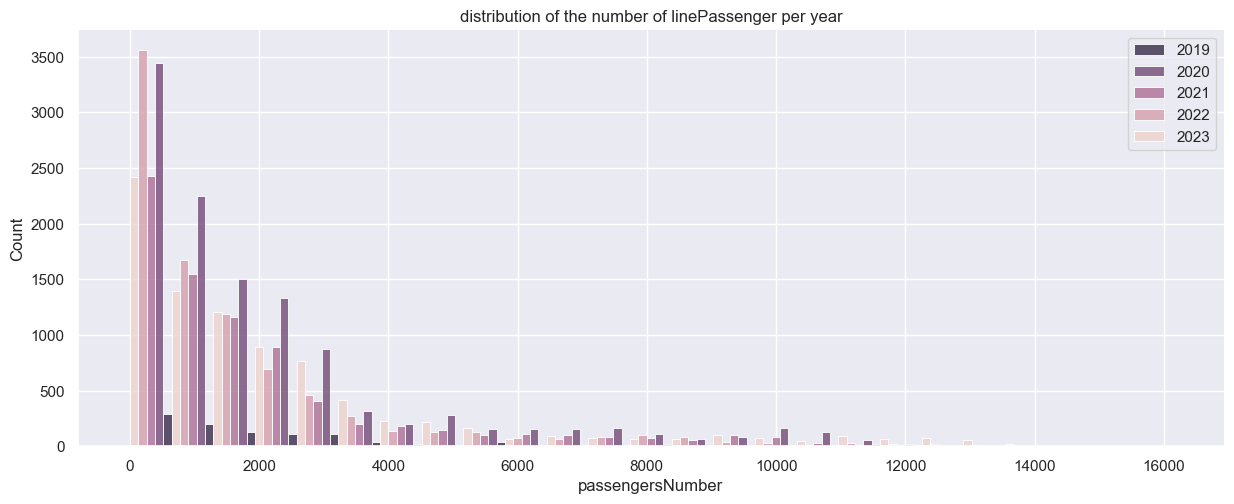

In [339]:
sns.displot(x='passengersNumber', data=data, hue='year', hue_order=yearpass, aspect=2.5, bins = 25, multiple='dodge', legend=False)
plt.title('distribution of the number of linePassenger per year')
plt.legend(yearpass, loc='upper right')
plt.show()

#Check for missing values

In [340]:
data.isna().any()

dateTime                    False
weather                     False
lineNumber                  False
passengersNumber            False
lineType                    False
year                        False
dateTimeMonth               False
dateTimeDay                 False
dateTimeWeek                False
day_of_year                 False
dateTimeDayofweek           False
dateTimeIs_sunday           False
is_holiday                  False
dateTimeIs_schoolholiday    False
dateTimeIs_paques           False
dateTimeIs_grandsemaine     False
nbPassenger_lag1            False
nbPassenger_lag2            False
nbPassenger_lag3            False
Dweather                     True
lineType_encoded            False
dtype: bool

#Split the data

In [351]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [352]:
X_train

,weather,year,dateTimeMonth,dateTimeWeek,dateTimeDay,day_of_year,dateTimeDayofweek,dateTimeIs_sunday,lineNumber,lineType_encoded,is_holiday,dateTimeIs_paques,nbPassenger_lag1,nbPassenger_lag2,nbPassenger_lag3,Dweather
14460,11,2020,8,33,14,227,4,False,35,1,False,False,1390.0,68.0,928.0,5
24719,11,2021,12,50,19,353,6,True,31,1,False,False,6386.0,305.0,1522.0,5
9518,23,2020,1,5,28,28,1,False,46,1,False,False,2795.0,1436.0,1557.0,3
1087,25,2019,5,19,8,128,2,False,17,1,False,False,1004.0,836.0,889.0,1
30133,43,2022,6,22,5,156,6,True,6,1,False,False,617.0,1509.0,2120.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16867,11,2020,10,44,30,304,4,False,31,1,False,False,170.0,1330.0,45.0,5
6283,44,2019,10,43,21,294,0,False,24,1,False,False,2243.0,4392.0,553.0,3
11295,24,2020,3,13,29,89,6,True,25,1,False,False,89.0,113.0,340.0,2
877,43,2019,5,18,1,121,2,False,25,1,False,False,1756.0,1455.0,1054.0,3


#Training the model


In [353]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train,y_train)

RandomForestRegressor()

#Evaluate the model

In [354]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score

# Model predictions
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 183.48856079734222
Root Mean Squared Error (RMSE): 169477.72590490367
R-squared (R²): 0.9729739808512614


In [355]:
# Assuming y_pred is a numpy array and y_test is a pandas Series or DataFrame column
comparison_df = pd.DataFrame({
    'Predicted': y_pred,
    'Actual': y_test
})

# Display the comparison
display(comparison_df)

,Predicted,Actual
1662,882.79,873
2605,10797.95,10297
20494,2432.88,2433
21535,1672.62,1732
7697,339.83,319
...,...,...
19002,562.05,569
31940,199.22,291
12255,593.87,388
35313,65.06,56


In [346]:
comparison_df.describe()

,Predicted,Actual
count,7525.000000,7525.000000
mean,2068.930958,2074.571827
std,2459.785732,2504.344857
min,6.080000,1.000000
25%,389.620000,374.000000
50%,1273.960000,1237.000000
75%,2522.090000,2565.000000
max,13814.080000,14392.000000
